In [1]:
# Imports
import importlib
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sys.path.append('../_shared_packages')
import process_cl2_logfile as process_cl2#This underline is unavoidable
importlib.reload(process_cl2)

# Load the file... (path,exp_name,ftir_path)
info = (('data/10-10-24_count_cl_excess_ch4.csv','10-10-24 Cl* Count w/ Excess CH4',None),
        ('data/12-10-24_humidity.csv','12-10-24 Humidity Sweep','data/12-10_ftir.prn'),
        ('data/11-8_radical_count_high_range.csv','11-8-24 Radical Count High Range',None),
        ('data/11-8_radical_count_low_range.csv','11-8-24 Radical Count Low Range',None),
        ('data/12-18_rad_count_low.csv','12-18-24 Radical Count 2-15 ppm',None),
        ('data/12-16_2ppm-CH4_sweep_cl2.csv','12-16-24 Sweep Cl2, 2ppm CH4','data/12-16_ftir.prn'),
        ('data/12-16_5ppm-CH4_sweep_cl2.csv','12-16-24 Sweep Cl2, 5ppm CH4','data/12-16_ftir.prn'),
        ('data/12-16_2ppm-CH4_sweep_cl2_1_5.csv','12-16-24 1 and 5 ppm Cl2, 2ppm CH4','data/12-16_ftir.prn'),
        ('data/12-2_light_distance_log_1.csv','12-2 Light Distance Log 1','data/12-2_ftir.prn'),
        ('data/12-2_light_distance_log_2.csv','12-2 Light Distance Log 2','data/12-2_ftir.prn'),
        ('data/12-2_light_distance_log_3.csv','12-2 Light Distance Log 3','data/12-2_ftir.prn'),
        ('data/12-2_light_distance_log_4.csv','12-2 Light Distance Log 4','data/12-2_ftir.prn'),
        )
hush=True
raw_data = process_cl2.extract_data([i[:2] for i in info],hush)

# Rebind the ftir
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)
for i in info:
    (path,exp_name,ftir_path)=i
    if ftir_path is not None:
        process_cl2.rebind_ftir_prn(raw_data[exp_name],ftir_path,ftir_fields_to_rebind,hush)

for df in raw_data.values():
    try:
        df['FTIR: CH2O (ppm)']+=0.5 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.
    except: #FTIR widget not used, or said 'no reading' the whole time.
        pass

# Suppress a printout
pass

/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/10-23 Cl2 Campaign Follow-Ups/../_shared_packages/process_cl2_logfile.py:38: DtypeWarning: Columns (46,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}
/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/10-23 Cl2 Campaign Follow-Ups/../_shared_packages/process_cl2_logfile.py:38: DtypeWarning: Columns (3,4,8,9,10,11,12,13,14,15,16,17,18,19,20,21,27,28,34,35,38,41,42,55,56,59,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}
/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/10-23 Cl2 Campaign Follow-Ups/../_shared_packages/process_cl2_logfile.py:38: DtypeWarning: Columns (19,20,21) have mixed types. Specify dtype option on import or set low_me

<h1> Loading, trimming, and re-binding log files </h1>

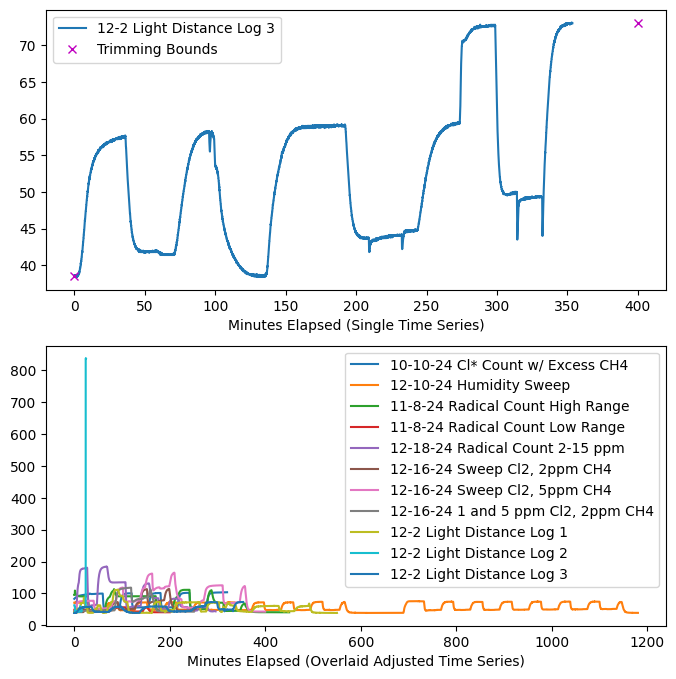

In [2]:
importlib.reload(process_cl2)
trim_params=((50,370),
             (20,1200),
             (50,500),
             (50,250),
             (0,300),
             (0,300),
             (0,400),
             (0,300),
             (0,550),
             (0,550),
             (0,400),
             (0,500)
             )
(data,ax1,ax2) = process_cl2.trim_dataframes(raw_data,trim_params,
                                #plot=True,which_field='Picarro: CH4 (ppm)',which_df=11)
                                   plot=True,which_field='Cl2 LabJack: Cl2 Node A (mV)',which_df=10)
rf = process_cl2.RemovalFinder(data,"10-23_cl2_misc_follow_ups")

<h1> First attempt to count *Cl </h1>

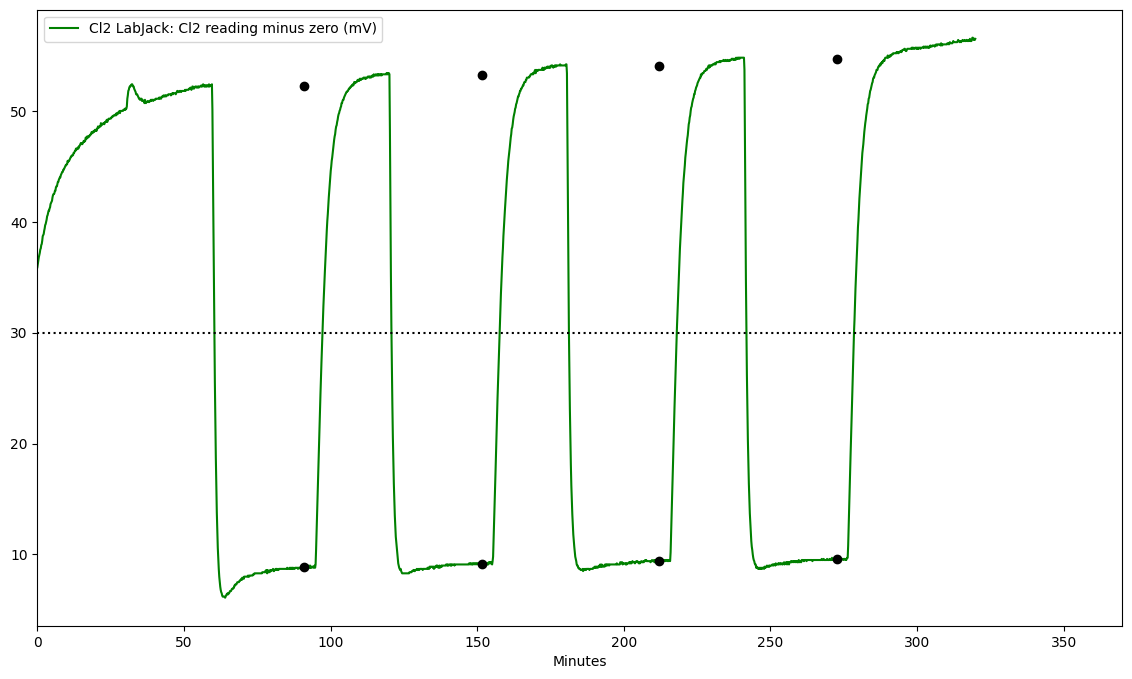

In [3]:
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-47.0)

importlib.reload(process_cl2)
current_experiment = '10-10-24 Cl* Count w/ Excess CH4'
rf.dump_experiment(current_experiment)

data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']


# Prep the plot region
(fig, axs) = plt.subplots(nrows=1,figsize=(14,8),sharex=True)
axs = [axs]

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the Cl2
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,370)

axs[0].set_xlabel("Minutes")

axs[0].plot([0,450],[30,30],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!

pass


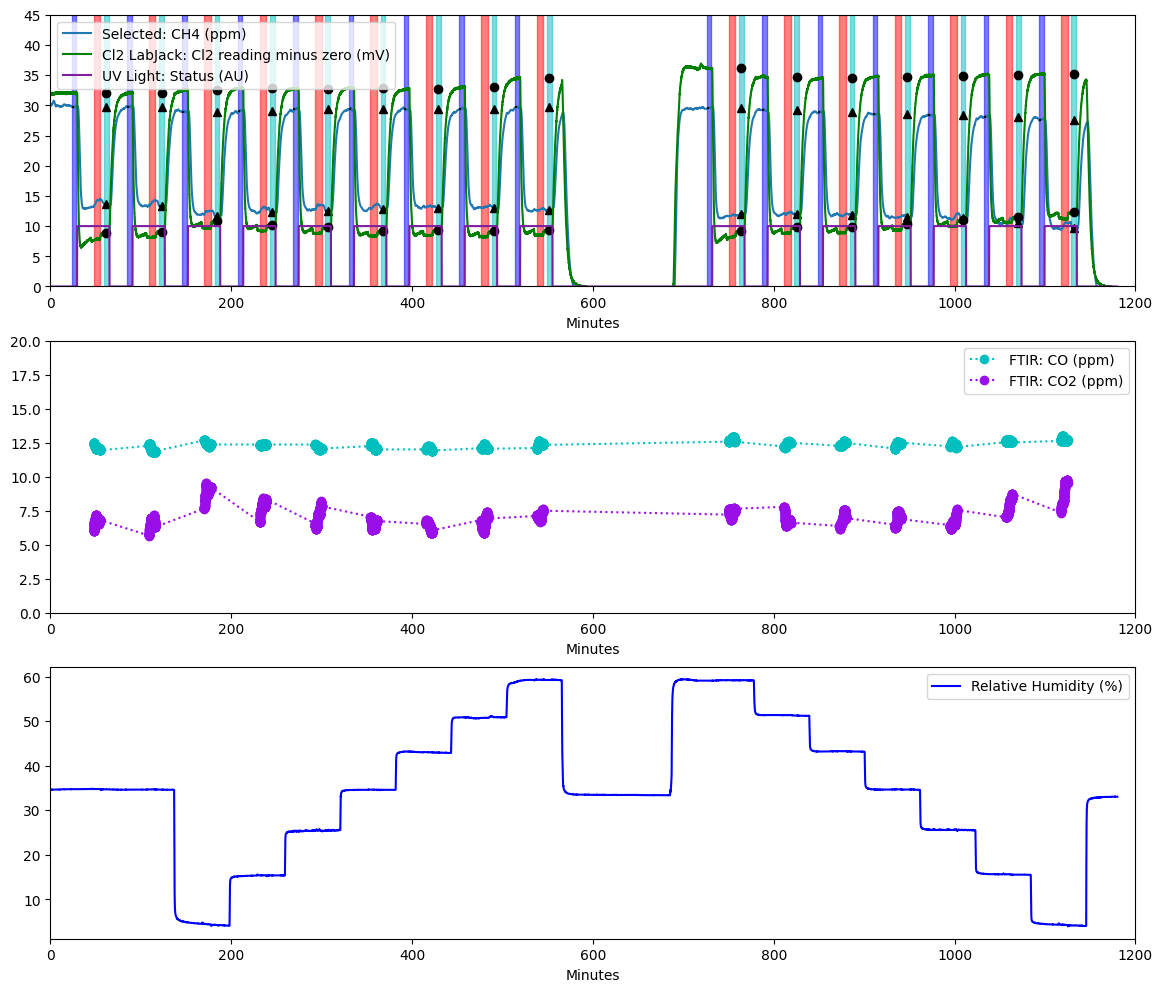

In [4]:
importlib.reload(process_cl2)
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-39.0)

current_experiment = '12-10-24 Humidity Sweep'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,12),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,500)
axs[0].set_ylim(0,45)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,20)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

# Throw in a plot of the RH
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['Humidity Probe: Rel. Humidity (%)']*(1.0/(1-6.0/200.0)),
        label='Relative Humidity (%)',color='b')
axs[2].set_xlim(0,1200)
axs[2].set_xlabel("Minutes")
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].legend()

pass

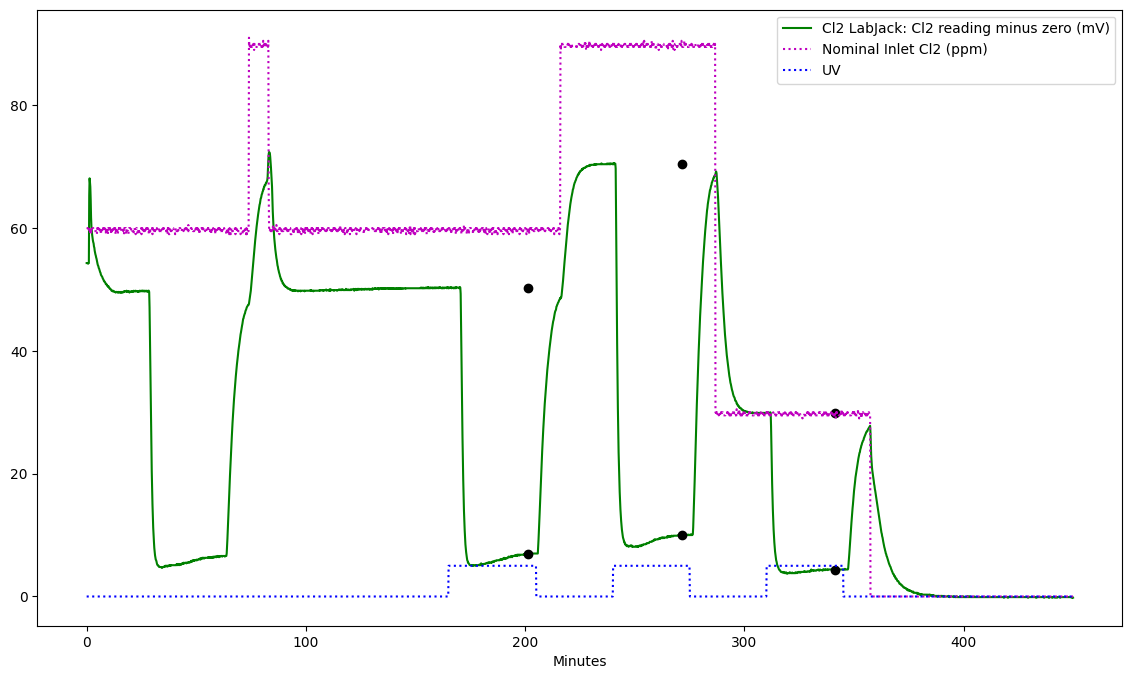

In [5]:
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-40.8)

importlib.reload(process_cl2)
current_experiment = '11-8-24 Radical Count High Range'
rf.dump_experiment(current_experiment)

data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Manually record when the UV light was on; we were controlling it by hand for this experiment.
data[current_experiment].loc[data[current_experiment]['Minutes']>-1, 'UV Light: Actual Status'] = 0
data[current_experiment].loc[data[current_experiment]['Minutes'].between(165,205), 'UV Light: Actual Status'] = 1
data[current_experiment].loc[data[current_experiment]['Minutes'].between(240,275), 'UV Light: Actual Status'] = 1
data[current_experiment].loc[data[current_experiment]['Minutes'].between(310,345), 'UV Light: Actual Status'] = 1

# Prep the plot region
(fig, axs) = plt.subplots(nrows=1,figsize=(14,8),sharex=True)
axs = [axs]

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the Cl2
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
#rf.manual_find_removal(current_experiment,sample_times=[200],baseline_times=[170])
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].legend()

axs[0].set_xlabel("Minutes")
axs[0].plot(data[current_experiment]['Minutes'],(1000.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')
axs[0].plot(data[current_experiment]['Minutes'],5*data[current_experiment]['UV Light: Actual Status'],'b:',label='UV')
axs[0].legend()

#axs[0].plot([0,450],[40.8,40.8],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!
pass


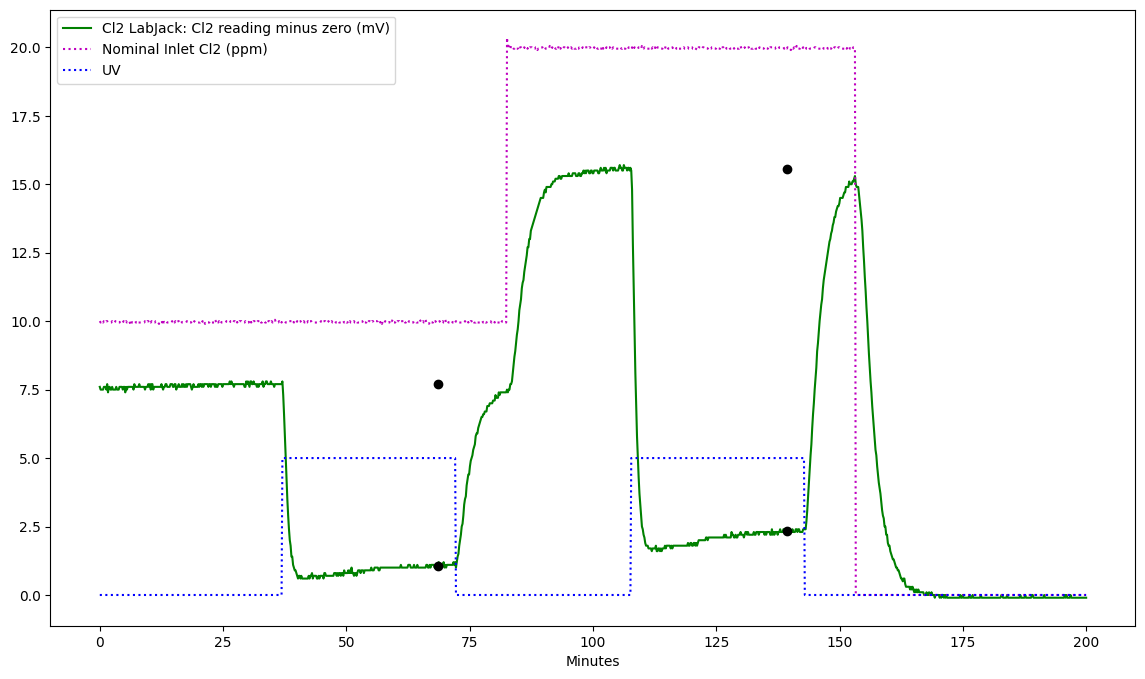

In [6]:
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-40.8)

importlib.reload(process_cl2)
current_experiment = '11-8-24 Radical Count Low Range'
rf.dump_experiment(current_experiment)

data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=1,figsize=(14,8),sharex=True)
axs = [axs]

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the Cl2
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
#rf.manual_find_removal(current_experiment,sample_times=[200],baseline_times=[170])
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].legend()

axs[0].set_xlabel("Minutes")
axs[0].plot(data[current_experiment]['Minutes'],(100.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')
axs[0].plot(data[current_experiment]['Minutes'],5*data[current_experiment]['UV Light: Actual Status'],'b:',label='UV')
axs[0].legend()

#axs[0].plot([0,450],[40.8,40.8],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!
pass


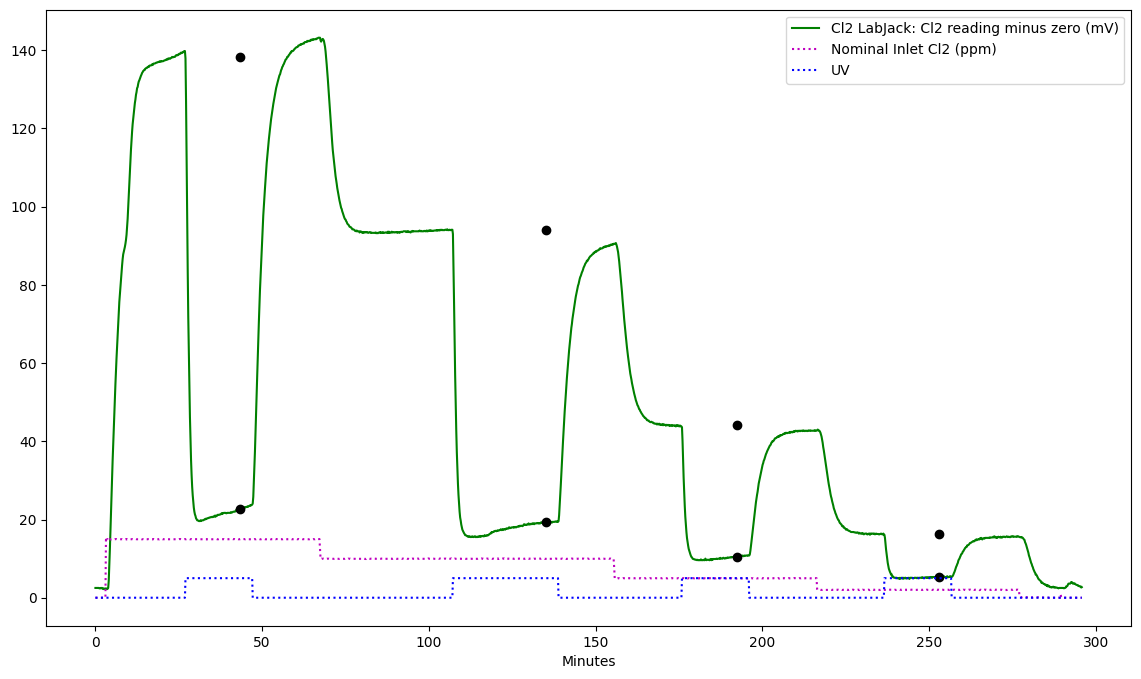

In [7]:
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-40.8)

importlib.reload(process_cl2)
current_experiment = '12-18-24 Radical Count 2-15 ppm'
rf.dump_experiment(current_experiment)

data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=1,figsize=(14,8),sharex=True)
axs = [axs]

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the Cl2
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
#rf.manual_find_removal(current_experiment,sample_times=[200],baseline_times=[170])
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].legend()

axs[0].set_xlabel("Minutes")
axs[0].plot(data[current_experiment]['Minutes'],(100.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')
axs[0].plot(data[current_experiment]['Minutes'],5*data[current_experiment]['UV Light: Actual Status'],'b:',label='UV')
axs[0].legend()

#axs[0].plot([0,450],[40.8,40.8],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!
pass


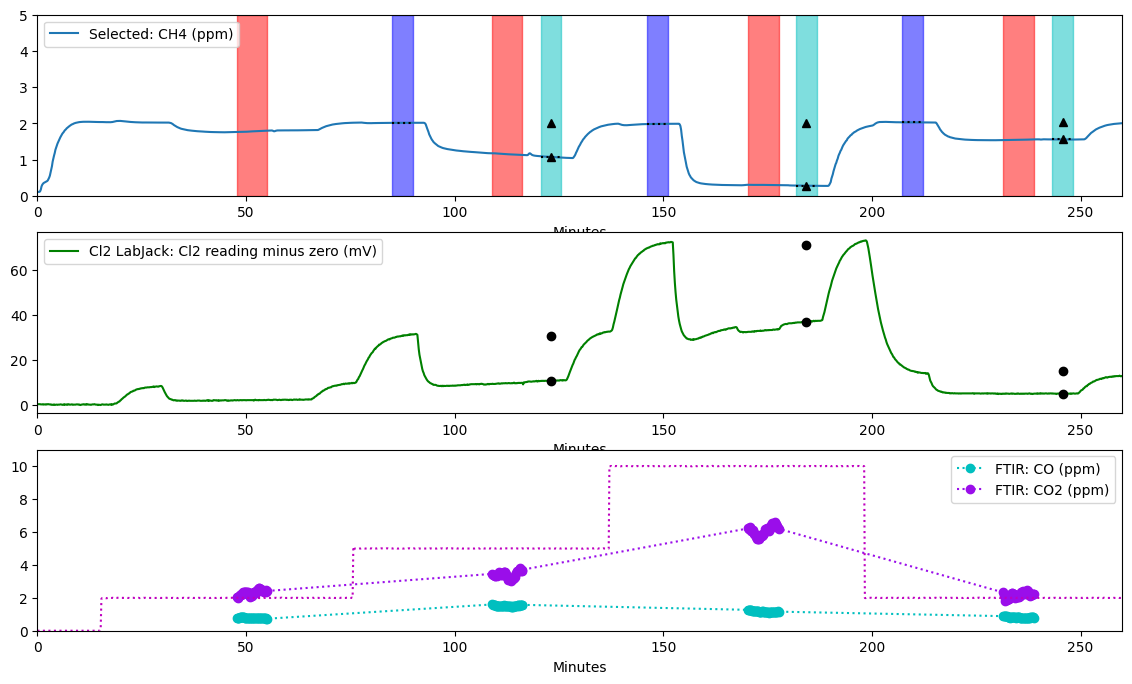

In [8]:
importlib.reload(process_cl2)
current_experiment = '12-16-24 Sweep Cl2, 2ppm CH4'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['Picarro: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=50,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=50,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[1],do_shading=False)
#axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet',label='CO2')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,260)
axs[0].set_ylim(0,5)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[2])
axs[2].set_ylim(0,11)
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_xlabel("Minutes")
axs[2].plot(data[current_experiment]['Minutes'],(20.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')

#axs[0].plot([0,450],[30,30],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!

pass


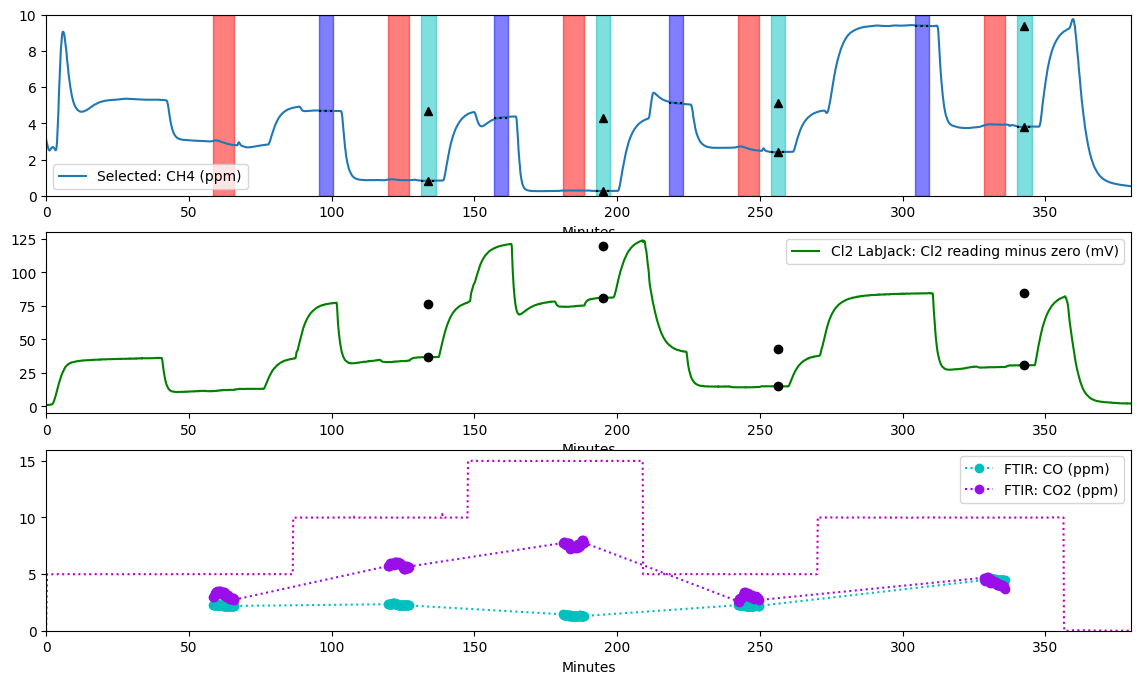

In [9]:
importlib.reload(process_cl2)
current_experiment = '12-16-24 Sweep Cl2, 5ppm CH4'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['Picarro: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=50,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=50,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[1],do_shading=False)
#axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet',label='CO2')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,380)
axs[0].set_ylim(0,10)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[2])
axs[2].set_ylim(0,16)
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_xlabel("Minutes")
axs[2].plot(data[current_experiment]['Minutes'],(20.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')

#axs[0].plot([0,450],[30,30],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!

pass


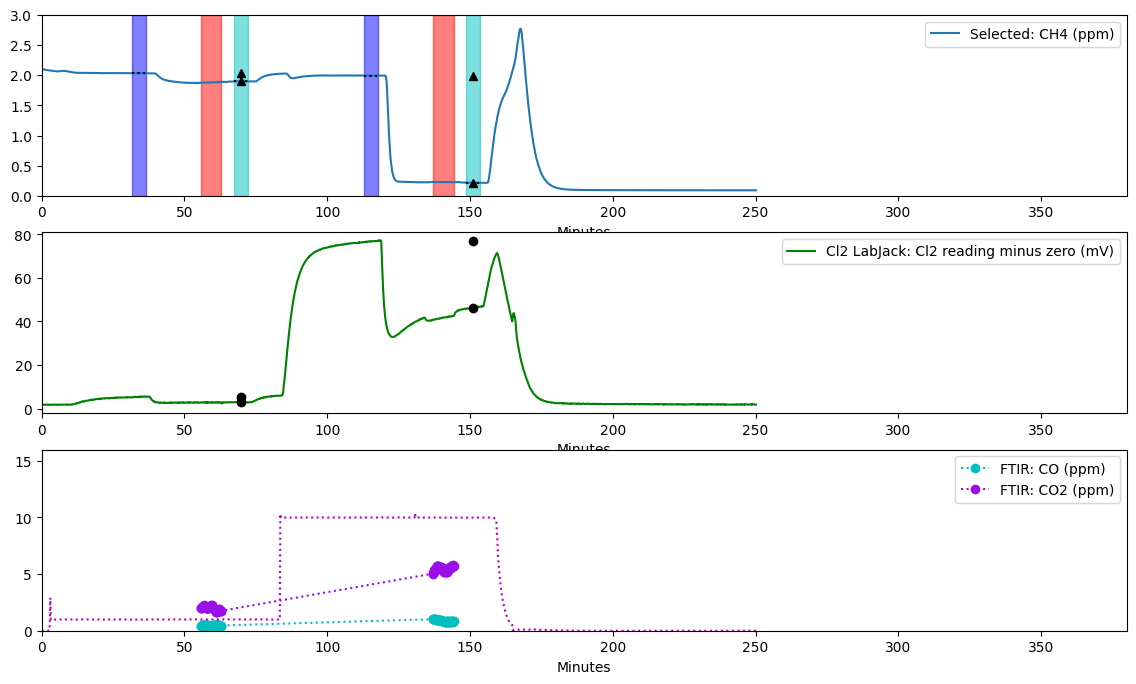

In [10]:
importlib.reload(process_cl2)
current_experiment = '12-16-24 1 and 5 ppm Cl2, 2ppm CH4'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['Picarro: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[1],do_shading=False)
#axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet',label='CO2')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,380)
axs[0].set_ylim(0,3)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[2])
axs[2].set_ylim(0,16)
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_xlabel("Minutes")
axs[2].plot(data[current_experiment]['Minutes'],(20.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')

#axs[0].plot([0,450],[30,30],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!

pass


Timestamp('2024-12-03 16:27:30')

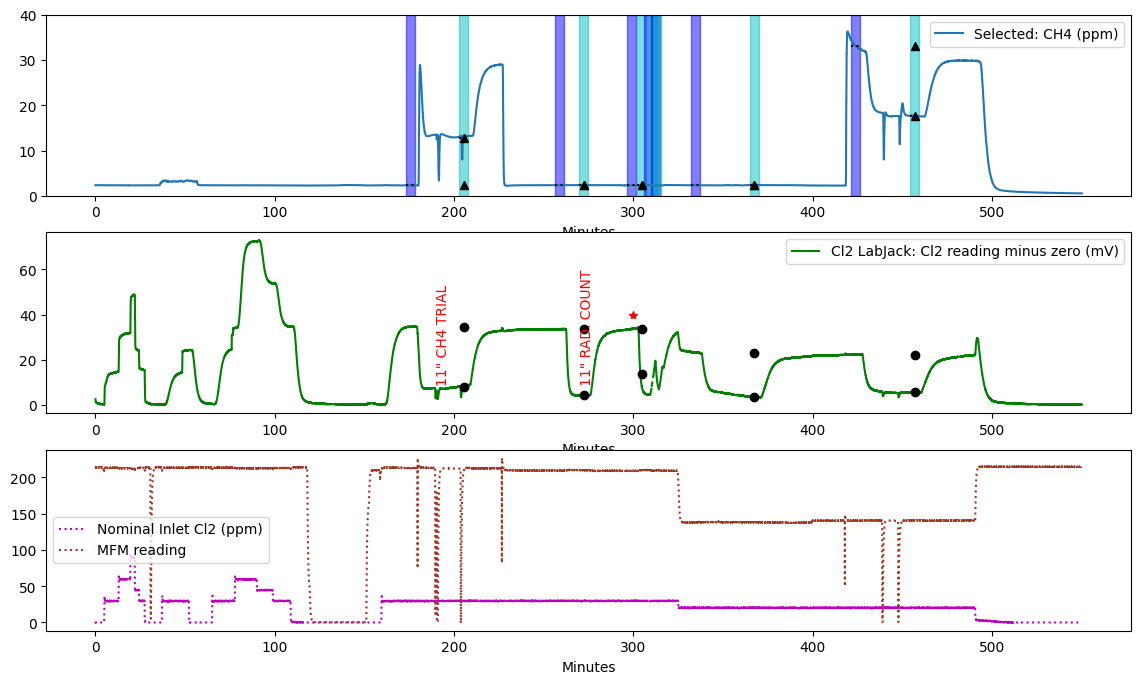

In [11]:
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-38.4)

importlib.reload(process_cl2)
current_experiment = '12-2 Light Distance Log 1'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['Picarro: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[1],do_shading=False)
#axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet',label='CO2')
axs[0].legend()

when = 300 #Code to help me match timestamps in my notes to features on the plot
axs[1].plot([when],[40],'r*')
display(data[current_experiment][ abs(data[current_experiment]['Minutes']-when)<0.1 ].iloc[0].Timestamp)

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
#axs[0].set_xlim(0,380)
axs[0].set_ylim(0,40)

axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_xlabel("Minutes")
axs[2].plot(data[current_experiment]['Minutes'],(1000.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['MFM: Actual Flow'],':',color='xkcd:brick',label='MFM reading')
axs[2].legend()

axs[1].text(270,10,"11\" RAD. COUNT",color='r',rotation=90)
axs[1].text(190,10,"11\" CH4 TRIAL",color='r',rotation=90)

#axs[0].plot([0,450],[30,30],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!

pass


Timestamp('2024-12-04 12:24:44')

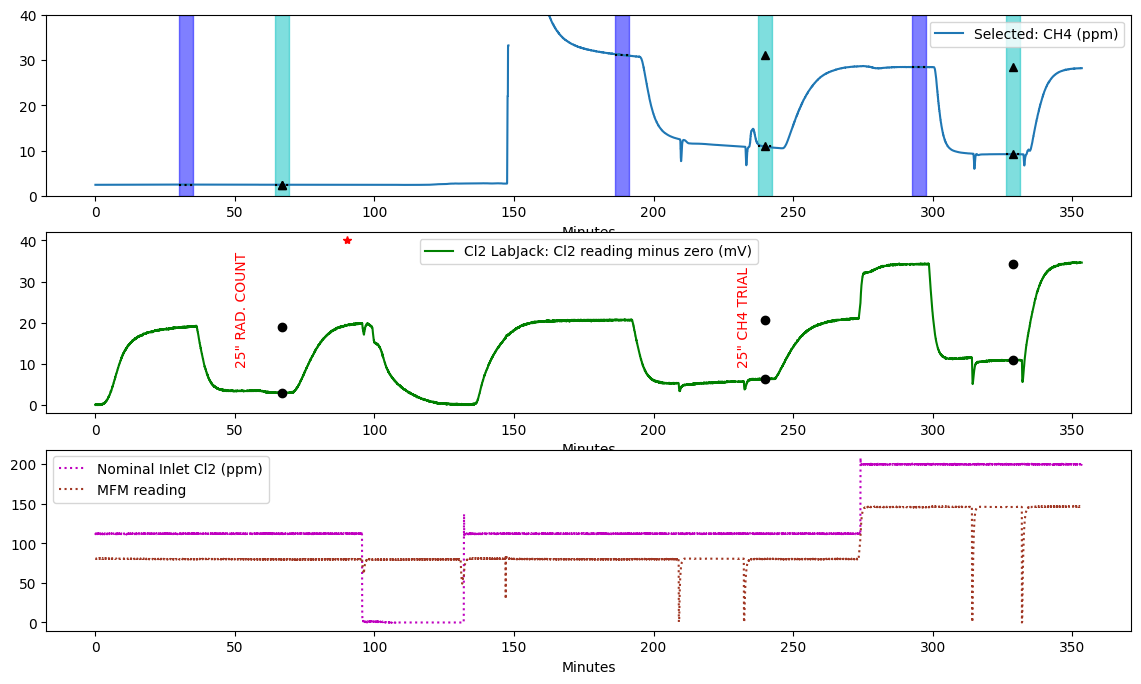

In [16]:
importlib.reload(process_cl2)
current_experiment = '12-2 Light Distance Log 3'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['Picarro: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[1],do_shading=False)
#axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet',label='CO2')
axs[0].legend()

when = 90 #Code to help me match timestamps in my notes to features on the plot
axs[1].plot([when],[40],'r*')
display(data[current_experiment][ abs(data[current_experiment]['Minutes']-when)<0.1 ].iloc[0].Timestamp)

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
#axs[0].set_xlim(0,380)
axs[0].set_ylim(0,40)

axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_xlabel("Minutes")
axs[2].plot(data[current_experiment]['Minutes'],(1000.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['MFM: Actual Flow'],':',color='xkcd:brick',label='MFM reading')
axs[2].legend()

axs[1].text(50,10,"25\" RAD. COUNT",color='r',rotation=90)
axs[1].text(230,10,"25\" CH4 TRIAL",color='r',rotation=90)
#axs[0].plot([0,450],[30,30],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!

pass


Timestamp('2024-12-09 12:46:00')

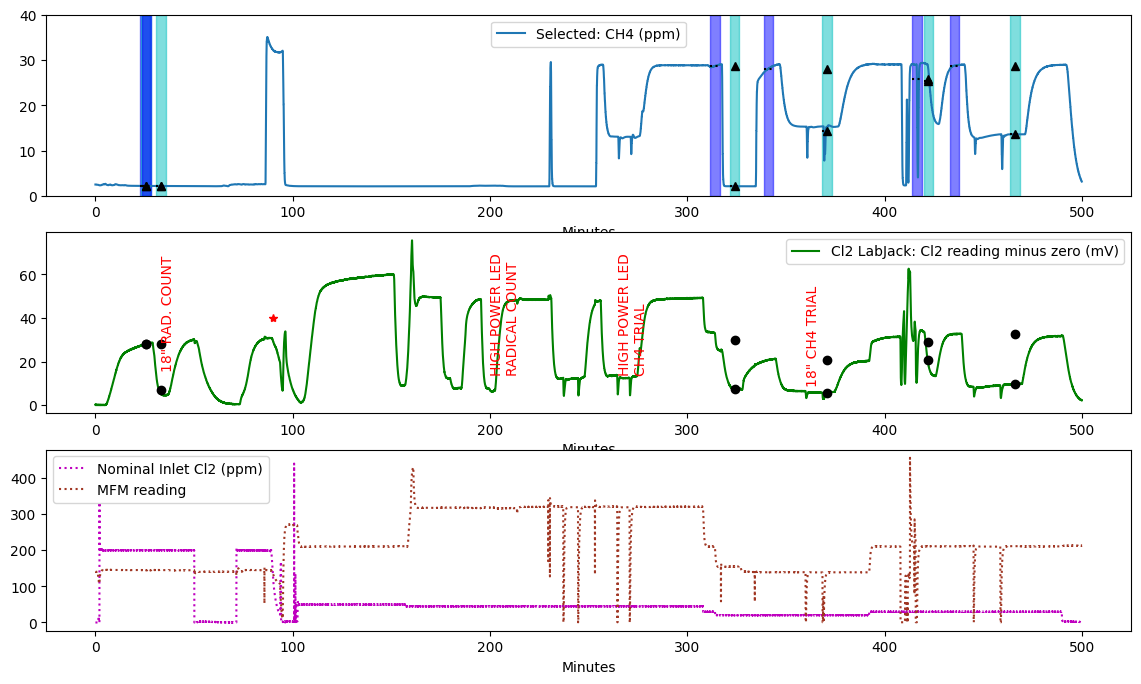

In [14]:
importlib.reload(process_cl2)
current_experiment = '12-2 Light Distance Log 4'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['Picarro: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=axs[1],do_shading=False)
#axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet',label='CO2')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
#axs[0].set_xlim(0,380)
axs[0].set_ylim(0,40)

axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_xlabel("Minutes")
axs[2].plot(data[current_experiment]['Minutes'],(1000.0/200.0)*data[current_experiment]['Cl2 MFC: Actual Flow'],'m:',label='Nominal Inlet Cl2 (ppm)')
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['MFM: Actual Flow'],':',color='xkcd:brick',label='MFM reading')
axs[2].legend()

when = 90 #Code to help me match timestamps in my notes to features on the plot
axs[1].plot([when],[40],'r*')
display(data[current_experiment][ abs(data[current_experiment]['Minutes']-when)<0.1 ].iloc[0].Timestamp)

#axs[0].plot([0,450],[30,30],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!
'''Monday 12-9:
- 11:15-13:00, tried to redo 100 ppm tank calibration for 18" position. We seemed to get 87% Cl2 conversion to Cl*, so didn't move the light.
- Ran out of 100 ppm after that.
- Rigged water-cooled LED panel after that with 1000 tank. 14:15 was a dud. 14:40 was radical count.
- Power supply stabilized to read 36V and 3.5A; I have iphone pictures to confirm.
- 15:15 and 15:45 are identical conversion trials with the powerful light. Second one used the Picarro. Manual bypass.
- 17:00, re-did 18" trial with residence time calculated with 100 tank. 16:45 is a dud; too much oxygen.
- 18:30, re-did trial in default configuration, 200 sccm of flow and 11" light.'''
axs[1].text(265,15,"HIGH POWER LED\nCH4 TRIAL",color='r',rotation=90)
axs[1].text(200,15,"HIGH POWER LED\nRADICAL COUNT",color='r',rotation=90)
axs[1].text(360,10,"18\" CH4 TRIAL",color='r',rotation=90)
axs[1].text(33,17,"18\" RAD. COUNT",color='r',rotation=90)

pass


In [15]:
#rf.export_conversion_results_to_csv('../_exported_data/')
#rf.export_bypass_periods('../_exported_data/')